In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn
import torchvision
from torchvision import datasets
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import DataLoader

In [2]:
device = torch.device('cuda:0')

In [3]:
class MNISTSampler:
    def __init__(self, train=True):
        dataset = datasets.MNIST(
            './mnist', train=train, download=True,
            transform=torchvision.transforms.ToTensor())
        indices = list(range(len(dataset)))
        np.random.RandomState(10).shuffle(indices)
        if train:
            indices = indices[:len(indices) // 2]
        else:
            indices = indices[len(indices) // 2:]

        self.loader = DataLoader(
            dataset, batch_size=128,
            sampler=torch.utils.data.sampler.SubsetRandomSampler(indices))
        self.loader = DataLoader(dataset, batch_size=128, shuffle=True)
    def sample(self):
        while True:
            for batch in self.loader:
                yield batch

In [4]:
class MLP(nn.Module):
    def __init__(self, num_layers=1, num_units=20, sampler=None, **kwargs):
        super().__init__()
        self.num_layers = num_layers
        if kwargs:
            self.params = kwargs
        else:
            self.params = {}
            in_size = 784
            for i in range(num_layers):
                self.params['linear_{:d}_W'.format(i)] =\
                    nn.Parameter(torch.randn(in_size, num_units) * 0.001)
                self.params['linear_{:d}_b'.format(i)] =\
                    nn.Parameter(torch.zeros(1, num_units))
                in_size = num_units
            self.params['final_W'] =\
                nn.Parameter(torch.randn(in_size, 10) * 0.001)
            self.params['final_b'] =\
                nn.Parameter(torch.zeros(1, 10))
            self.mods = nn.ParameterList([v for v in self.params.values()])
        self.act = nn.Sigmoid()
        self.loss = nn.CrossEntropyLoss()
    def _linear_forward(self, h, W, b, act=True):
        h = torch.matmul(h, W) + b
        if act:
            h = self.act(h)
        return h
    def forward(self, sampler):
        batch = next(sampler)
        x, target = batch[0].to(device), batch[1].to(device)
        h = x.view(x.size(0), -1)
        for i in range(self.num_layers):
            h = self._linear_forward(h, self.params['linear_{:d}_W'.format(i)], self.params['linear_{:d}_b'.format(i)])
        y = self._linear_forward(h, self.params['final_W'], self.params['final_b'], act=False)
        return self.loss(y, target)

In [5]:
class SGD:
    def __init__(self, lr=1e-2):
        self.lr = lr
    def __call__(self, grads):
        updates = {}
        for k, v in grads.items():
            updates[k] = -self.lr * v
        return updates
class RMSProp:
    def __init__(self, lr=1e-2, decay=0.99):
        self.lr = lr
        self.decay = decay
        self.state = None
    def __call__(self, grads):
        if self.state is None:
            self.state = {}
            for k, v in grads.items():
                self.state[k] = torch.zeros_like(v)
        updates = {}
        for k, v in grads.items():
            state = self.state[k]
            state = self.decay * state + (1 - self.decay) * torch.pow(v, 2)
            self.state[k] = state
            updates[k] = -self.lr * v / (torch.sqrt(state) + 1e-6)
        return updates

In [6]:
losses = {'iter': [], 'loss': [], 'optim': []}

In [7]:
for _ in tqdm(range(10)):
    mlp = MLP()
    mlp = mlp.to(device)
    sgd = torch.optim.SGD(mlp.parameters(), lr=1e-2)
    sampler = MNISTSampler().sample()
    for i in range(100):
        y = mlp(sampler)
        losses['iter'].append(i)
        losses['loss'].append(float(y.data.cpu().numpy()))
        losses['optim'].append('SGD')
        mlp.zero_grad()
        y.backward()
        sgd.step()

In [8]:
for _ in tqdm(range(10)):
    mlp = MLP()
    mlp = mlp.to(device)
    sgd = torch.optim.SGD(mlp.parameters(), momentum=0.9, lr=1e-2)
    sampler = MNISTSampler().sample()
    for i in range(100):
        y = mlp(sampler)
        losses['iter'].append(i)
        losses['loss'].append(float(y.data.cpu().numpy()))
        losses['optim'].append('SGD+Momentum')
        mlp.zero_grad()
        y.backward()
        sgd.step()

In [13]:
for _ in tqdm(range(10)):
    mlp = MLP()
    mlp = mlp.to(device)
    sgd = torch.optim.SGD(mlp.parameters(), momentum=0.9, lr=1e-2, nesterov=True)
    sampler = MNISTSampler().sample()
    for i in range(100):
        y = mlp(sampler)
        losses['iter'].append(i)
        losses['loss'].append(float(y.data.cpu().numpy()))
        losses['optim'].append('SGD+NMomentum')
        mlp.zero_grad()
        y.backward()
        sgd.step()

In [9]:
for _ in tqdm(range(10)):
    mlp = MLP()
    mlp = mlp.to(device)
    adam = torch.optim.Adam(mlp.parameters(), lr=1e-2)
    sampler = MNISTSampler().sample()
    for i in range(100):
        y = mlp(sampler)
        losses['iter'].append(i)
        losses['loss'].append(float(y.data.cpu().numpy()))
        losses['optim'].append('Adam')
        mlp.zero_grad()
        y.backward()
        adam.step()

In [10]:
for _ in tqdm(range(10)):
    mlp = MLP()
    mlp = mlp.to(device)
    rms = torch.optim.RMSprop(mlp.parameters(), lr=1e-2)
    sampler = MNISTSampler().sample()
    for i in range(100):
        y = mlp(sampler)
        losses['iter'].append(i)
        losses['loss'].append(float(y.data.cpu().numpy()))
        losses['optim'].append('RMSProp')
        mlp.zero_grad()
        y.backward()
        rms.step()

In [11]:
# Custom RMSProp
# for _ in range(10):
#     mlp = MLP()
#     rms = RMSProp()
#     for i in range(100):
#         y = mlp()
#         losses['iter'].append(i)
#         losses['loss'].append(float(y.data.cpu().numpy()))
#         losses['optim'].append('RMSProp')
#         mlp.zero_grad()
#         y.backward()
#         grads = {}
#         for k in mlp.params.keys():
#             grads[k] = mlp.params[k].grad.detach()
#         updates = rms(grads)
#         for k in mlp.params.keys():
#             mlp.params[k].data += updates[k]
#     print(y.item())

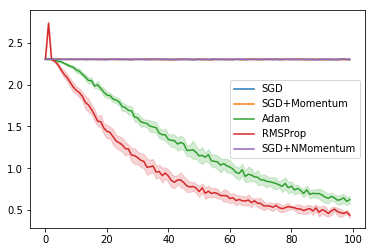

In [14]:
seaborn.lineplot(x='iter', y='loss', hue='optim', data=losses)
plt.show()

In [15]:
class MetaOptimizer(nn.Module):
    def __init__(self, dim=1, hidden=20, out=1, layers=2, preprocess=False):
        super().__init__()
        self.hidden = hidden
        self.layers = layers
        self.preprocess = preprocess
        if preprocess:
            dim = 2
            self.p_factor = 10.
            self.p_threshold = np.exp(-self.p_factor)
        self.lstm = nn.LSTM(input_size=dim, hidden_size=hidden, num_layers=layers)
        self.linear = nn.Linear(hidden, out)
    def forward(self, grad, state=None):
        # seq_len x batch x size
        grad = grad.view(1, -1, 1)
        if state is None:
            h = torch.zeros(self.layers, grad.size()[1], self.hidden)
            c = torch.zeros(self.layers, grad.size()[1], self.hidden)
            h = h.to(device)
            c = c.to(device)
            state = (h, c)
        if self.preprocess:
            inp = grad.data.squeeze()
            inp2 = torch.zeros(inp.size(0), 2).to(device)
            keep_grads = (torch.abs(inp) >= self.p_threshold)
            inp2[:, 0][keep_grads] = (torch.log(torch.abs(inp[keep_grads]) + 1e-8) / self.p_factor)
            inp2[:, 1][keep_grads] = torch.sign(inp[keep_grads])
            
            inp2[:, 0][~keep_grads] = -1
            inp2[:, 1][~keep_grads] = (float(np.exp(self.p_factor)) * inp[~keep_grads])
            grad = inp2.view(1, -1, 2)
            grad.requires_grad = True
        lstm_out, state = self.lstm(grad, state)
        # lstm_out.shape: seq_len x batch x hidden
        update = self.linear(lstm_out.view(-1, self.hidden))
        return update, state

In [22]:
# torch.manual_seed(0)
# np.random.seed(0)
meta_optimizer = MetaOptimizer(preprocess=True)
meta_optimizer_optim = torch.optim.Adam(meta_optimizer.parameters(), lr = 1e-2)
meta_optimizer = meta_optimizer.to(device)

In [23]:
out_mul = 0.1
pbar = tqdm(range(200))
state = None
for k in pbar:
    mlp = MLP()
    mlp = mlp.to(device)
    states = {k: None for k in mlp.params.keys()}
    sampler = MNISTSampler().sample()
    for l in tqdm(range(5), leave=False):
        loss = 0.
        temp_params = {}
        for i in range(20):
            y = mlp(sampler)
            loss += y
            mlp.zero_grad()
            y.backward(retain_graph=True)
            grads = {}
            for k in mlp.params.keys():
                grads[k] = mlp.params[k].grad.detach()
            updates = {}
            for k in grads.keys():
                updates[k], states[k] = meta_optimizer(grads[k], states[k])
            for k in updates.keys():
                temp_params[k] = mlp.params[k] + updates[k].view_as(mlp.params[k]) * out_mul
                temp_params[k].retain_grad()
            mlp = MLP(**temp_params)
        for k in states.keys():
            states[k] = (states[k][0].detach().clone(), states[k][1].detach().clone())
            states[k][0].retain_grad()
            states[k][1].retain_grad()
        meta_optimizer_optim.zero_grad()
        loss.backward(retain_graph=True)
        meta_optimizer_optim.step()
    pbar.set_description('Loss: %.3f' % loss.item())

In [24]:
meta_optimizer.eval()
for _ in tqdm(range(10)):
    mlp = MLP()
    mlp = mlp.to(device)
    states = {k: None for k in mlp.params.keys()}
    sampler = MNISTSampler().sample()
    for i in range(100):
        y = mlp(sampler)
        losses['iter'].append(i)
        losses['loss'].append(float(y.data.cpu().numpy()))
        losses['optim'].append('L2L')
        mlp.zero_grad()
        y.backward(retain_graph=True)
        grads = {}
        for k in mlp.params.keys():
            grads[k] = mlp.params[k].grad.detach()
        updates = {}
        for k in grads.keys():
            updates[k], states[k] = meta_optimizer(grads[k], states[k])
        for k in updates.keys():
            mlp.params[k].data = mlp.params[k].data + updates[k].view_as(mlp.params[k]) * out_mul

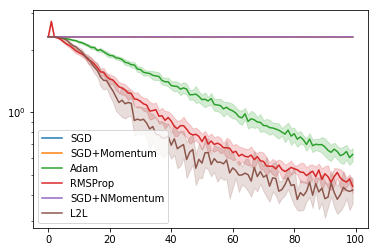

In [25]:
ax = seaborn.lineplot(x='iter', y='loss', hue='optim', data=losses)
ax.set_yscale('log')
plt.show()

In [26]:
torch.save(meta_optimizer.state_dict(), 'meta-mnist.pt')
torch.save(meta_optimizer_optim.state_dict(), 'meta-mnist-adam.pt')